# Evaluating multiple combinations of models and encoders to segment clouds in satellite images

* Leandro Henrique Furtado Pinto Silva
* Mauricio Cunha Escarpinati
* André Ricardo Backes - arbackes@yahoo.com.br
* João Fernando Mari - joaof.mari@ufv.br
---
* Code for the paper published at CCIS 2024.
    * It is a extension of the paper published at VISAPP 2024 - Rome, Italy.
---

## Importing libraries
---

In [1]:
import time
import os
import sys
import argparse
import random
import pickle
from pathlib import Path

import numpy as np 
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import PIL
from PIL import Image
import cv2
from IPython.display import display

### import tifffile

import skimage
from skimage import img_as_ubyte, exposure
import sklearn
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms as T

import torchvision
import torch.nn.functional as F
from torch.autograd import Variable

import albumentations as A

### from tqdm.notebook import tqdm

from torchsummary import summary
import segmentation_models_pytorch as smp

# Métricas baseadas no artigo "Fully Convolutional Networks for Semantic Segmentation"
# https://github.com/martinkersner/py_img_seg_eval/blob/master/eval_segm.py
from eval_segm import pixel_accuracy, mean_accuracy, mean_IU, frequency_weighted_IU

In [2]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

# https://github.com/qubvel/segmentation_models.pytorch/issues/675

## Checking if CUDA is available
---

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [4]:
parser = argparse.ArgumentParser()
parser.add_argument('--config', help="Configuration file *.yml", type=str, required=False, default=None)
### parser.add_argument('--ctrl', help="Control string", type=str, required=False, default='')

parser.add_argument('--mode', help="Train (train and eval) or Eval.", type=str, required=False, default='train')

parser.add_argument('--dataset_name', help="Name of the used dataset.", type=str, required=False, default='38cloud')
parser.add_argument('--model', help="An SMP model.", type=str, required=False, default='Unet')
parser.add_argument('--backbone', help="A SMP backbone.", type=str, required=False, default='mobilenet_v2')
parser.add_argument('--pretrained', help="Train over a pretrained (with ImageNet) backbone. [None, 'imagenet']",  type=str, required=False, default='imagenet')
parser.add_argument('--loss', help="The loss function. ['crossentropy', 'dice']",  type=str, required=False, default='crossentropy')
parser.add_argument('--seed', help="Seed for random number generation.", type=int, required=False, default=42)
parser.add_argument('--max_epochs', help="Maximum number od epochs.", type=int, required=False, default=1000)
parser.add_argument('--batch_size', help="Batch size.", type=int, required=False, default=16)
parser.add_argument('--lr', help="Learning rate.", type=float, required=False, default=0.0001)
parser.add_argument('--weight_decay', help="Weight decay.", type=float, required=False, default=0.0004)
parser.add_argument('--patience', help="Patience for early stoping.", type=int, required=False, default=21)

parser.add_argument('--scheduler', help="The scheduler strategy. ['onecycle', 'cossine', 'plateau']", type=str, required=False, default='plateau')

parser.add_argument('--first_run', help="First eperiment?", required=False, default=False,  action=argparse.BooleanOptionalAction)
parser.add_argument('--hp_optim', help="HP optimization?", required=False, default=False, action=argparse.BooleanOptionalAction)
parser.add_argument('--debug', help="Is running in debug mode?", required=False, default=False, action='store_true')

parser.add_argument('--ec', help='Experiment counter. Used for hp optimization.', type=int, default=0)

### parser.add_argument('--smp_reduction', help="Reduction for smp metrics. ['micro', 'macro', 'weighted', 'micro-imagewise', 'macro-imagewise', 'weighted-imagewise', 'none]", type=str, required=False, default='micro-imagewise')

# ***** IMPORTANTE!!! *****
# Comentar esta linha após gerar o arquivo .py!
# *************************
sys.argv = ['-f']

args = parser.parse_args()

# Set DEBUG mode:
args.debug = True

if args.debug:
    ### args.ctrl = '1'
    args.mode = 'train'    
    # args.model = 'MAnet'
    # args.backbone = 'densenet121'
    args.max_epochs = 3
    args.ec = 0
    ### args.smp_reduction = 'macro-imagewise'
    args.first_run = True

if args.pretrained == 'None':
    args.pretrained = None

In [5]:
EXP_PATH_MAIN = f'exp_{args.dataset_name}'
### EXP_PATH_MAIN = f'exp_{str(args.ec).zfill(2)}_{args.dataset_name}'

if args.hp_optim:
    EXP_PATH_MAIN = f'exp_hp_{args.dataset_name}'
    
if args.debug:
    EXP_PATH_MAIN = f'exp_debug_{args.dataset_name}'

EXP_PATH = os.path.join(EXP_PATH_MAIN, 
                        ### f'exp_{args.model}_{args.backbone}_{args.pretrained}_{args.batch_size}_{args.lr}_{args.max_epochs}_{args.scheduler}_{args.ctrl}')
                        f'exp_{str(args.ec).zfill(2)}_{args.model}_{args.backbone}_{args.pretrained}_{args.batch_size}_{args.lr}_{args.max_epochs}_{args.scheduler}')

if not os.path.exists(EXP_PATH):
    os.makedirs(EXP_PATH)

if args.mode == 'train':
        # If the folder already exists, it is possible the experiment should (or shouldn't) be complete.
        # Nós verificamos, observando se o arquivo 'done.txt' está na pasta.
        # O arquivo 'done.txt' só é criado quando o experimento terminou por completo.
        if os.path.exists(os.path.join(EXP_PATH, 'done.txt')):
            # The folder exists and the experiment is done.
            print('Experiment already done. Finishing the program...')
            print('\nDone!\n\n')
            sys.exit()

In [6]:
args_str = ''
for arg in vars(args):
    args_str += f'\n{arg}: {getattr(args, arg)}'
    print(f'{arg}: {getattr(args, arg)}')

config: None
mode: train
dataset_name: 38cloud
model: Unet
backbone: mobilenet_v2
pretrained: imagenet
loss: crossentropy
seed: 42
max_epochs: 3
batch_size: 16
lr: 0.0001
weight_decay: 0.0004
patience: 21
scheduler: plateau
first_run: True
hp_optim: False
debug: True
ec: 0


In [7]:
def get_versions():
    str = ''
    str += f'\nNumPy: {np.__version__}'
    str += f'\nMatplotlib: {matplotlib.__version__}'
    str += f'\nPandas: {pd.__version__}'
    str += f'\nPIL: {PIL.__version__}'
    str += f'\nCV: {cv2.__version__}'
    str += f'\nScikit-image: {skimage.__version__}'
    str += f'\nScikit-learn: {sklearn.__version__}'
    str += f'\nPyTorch: {torch.__version__}'
    str += f'\nTorchvision: {torchvision.__version__}'
    str += f'\nAlbumentations: {A.__version__}'
    str += f'\nSMP: {smp.__version__}'

    return str

print(get_versions())


NumPy: 1.24.3
Matplotlib: 3.7.1
Pandas: 1.5.3
PIL: 9.4.0
CV: 4.7.0
Scikit-image: 0.19.3
Scikit-learn: 1.2.0
PyTorch: 2.0.1
Torchvision: 0.15.2
Albumentations: 1.3.0
SMP: 0.3.2


In [8]:
with open(os.path.join(EXP_PATH, f'general_report.txt'), 'w') as model_file:
    model_file.write('\n\nArguments:')
    model_file.write(args_str)
    model_file.write('\n\nPackage versions:')
    model_file.write(str(get_versions()))

## Reprodutibility configurations
---

In [9]:
random.seed(args.seed)
np.random.seed(args.seed)

torch.manual_seed(args.seed)
torch.cuda.manual_seed(args.seed)

torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

## Preprocessing
---

In [10]:
TRAIN_PATH = '/home/joao/Datasets/38-Cloud/38-Cloud_training/'
TEST_PATH = '/home/joao/Datasets/38-Cloud/38-Cloud_test/'

In [11]:
IN_CHANNELS = 4
N_CLASSES = 2 

df_train = pd.read_csv(os.path.join(TRAIN_PATH, 'training_patches_38-Cloud.csv'), skiprows=1, header=None, names=['id'])
df_test = pd.read_csv(os.path.join(TEST_PATH, 'test_patches_38-Cloud.csv'), skiprows=1, header=None, names=['id'])

print('Total images (training): ', len(df_train))
print('Total images (test): ', len(df_test))

with open(os.path.join(EXP_PATH, f'general_report.txt'), 'a') as model_file:
    model_file.write(f'\n\nTotal images (training): {len(df_train)}')
    model_file.write(f'\nTotal images (test): {len(df_test)}')

display(df_train)
display(df_test)    

Total images (training):  8400
Total images (test):  9201


,id
0,patch_1_1_by_1_LC08_L1TP_002053_20160520_20170...
1,patch_1_1_by_1_LC08_L1TP_002054_20160520_20170...
2,patch_1_1_by_1_LC08_L1TP_011002_20160620_20170...
3,patch_1_1_by_1_LC08_L1TP_011247_20160620_20170...
4,patch_1_1_by_1_LC08_L1TP_029040_20160720_20170...
...,...
8395,patch_99_5_by_15_LC08_L1TP_047023_20160920_201...
8396,patch_99_5_by_19_LC08_L1TP_002053_20160520_201...
8397,patch_99_5_by_19_LC08_L1TP_002054_20160520_201...
8398,patch_99_5_by_3_LC08_L1TP_011002_20160620_2017...


,id
0,patch_1_1_by_1_LC08_L1TP_003052_20160120_20170...
1,patch_1_1_by_1_LC08_L1TP_018008_20160520_20170...
2,patch_1_1_by_1_LC08_L1TP_029032_20160720_20170...
3,patch_1_1_by_1_LC08_L1TP_029041_20160720_20170...
4,patch_1_1_by_1_LC08_L1TP_029044_20160720_20170...
...,...
9196,patch_99_5_by_19_LC08_L1TP_039035_20160320_201...
9197,patch_99_5_by_3_LC08_L1TP_018008_20160520_2017...
9198,patch_99_5_by_7_LC08_L1TP_063012_20160920_2017...
9199,patch_99_5_by_7_LC08_L1TP_063013_20160920_2017...


In [12]:
# split data
if args.dataset_name == '38cloud':
    # 30% para validação, 70% para treino
    X_train, X_val = train_test_split(df_train['id'].values, test_size=0.30, random_state=42)
    X_test = df_test['id'].values

print('Train Size   : ', len(X_train))
print('Val Size     : ', len(X_val))
print('Test Size    : ', len(X_test))

with open(os.path.join(EXP_PATH, f'general_report.txt'), 'a') as model_file:
        model_file.write(f'\n\nTrain Size: {len(X_train)}')
        model_file.write(f'\nVal Size: { len(X_val)}')
        model_file.write(f'\nTest Size: { len(X_test)}')

Train Size   :  5880
Val Size     :  2520
Test Size    :  9201


Image Size (384, 384) uint16 0 65535
Image Size 2 (384, 384, 3) uint8 0 255
Mask Size (384, 384)


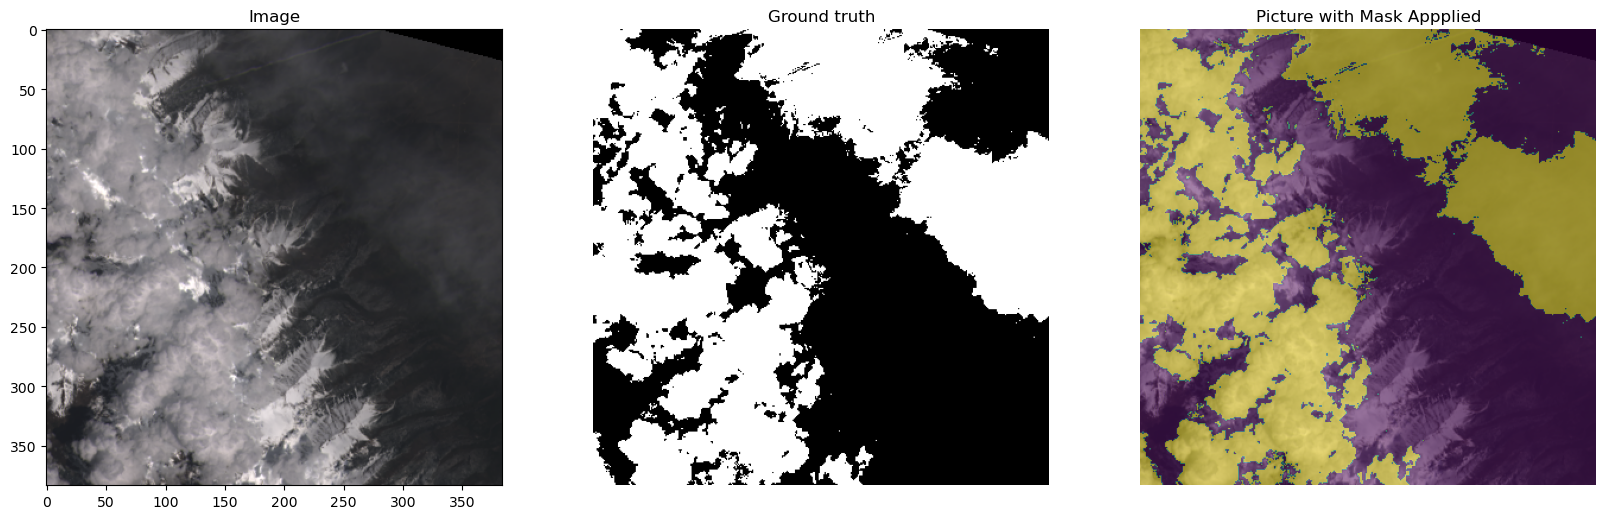

In [13]:
if args.mode == 'train':
    img = Image.open(os.path.join(TRAIN_PATH, 'train_red', 'red_' + df_train['id'][100] + '.TIF'))

    img_rgb = np.stack([np.array(Image.open(os.path.join(TRAIN_PATH, 'train_red', 'red_' + df_train['id'][100] + '.TIF'))),
                        np.array(Image.open(os.path.join(TRAIN_PATH, 'train_green', 'green_' + df_train['id'][100] + '.TIF'))),
                        np.array(Image.open(os.path.join(TRAIN_PATH, 'train_blue', 'blue_' + df_train['id'][100] + '.TIF'))), ], axis=2)

    # Convert from 16 bit to 8 bit
    img_rgb = img_as_ubyte(img_rgb)

    mask = Image.open(os.path.join(TRAIN_PATH, 'train_gt', 'gt_' + df_train['id'][100] + '.TIF'))
    print('Image Size', np.asarray(img).shape, np.asarray(img).dtype, np.asarray(img).min(), np.asarray(img).max(), )
    print('Image Size 2', np.asarray(img_rgb).shape, np.asarray(img_rgb).dtype, np.asarray(img_rgb).min(), np.asarray(img_rgb).max(), )
    print('Mask Size', np.asarray(mask).shape)

    fig_obj, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20,10))
    ax1.imshow(img_rgb)
    ax1.set_title('Image')

    ax2.imshow(mask, cmap='gray')
    ax2.set_title('Ground truth')
    ax2.set_axis_off()

    ax3.imshow(img_rgb)
    ax3.imshow(mask, alpha=0.5)
    ax3.set_title('Picture with Mask Appplied')
    ax3.set_axis_off()

    plt.savefig(os.path.join(EXP_PATH, 'sample_batch.png')) 
    plt.savefig(os.path.join(EXP_PATH, 'sample_batch.pdf')) 
    # with open(os.path.join(EXP_PATH, 'sample_batch.pickle'), 'wb') as file:
    #     pickle.dump(fig_obj, file)

## Datasets
---

In [14]:
class CloudDataset(Dataset):
    """ Dataset - conjunto de treinamento.

    Reference
    ---------
    https://medium.com/analytics-vidhya/how-to-create-a-custom-dataset-loader-in-pytorch-from-scratch-for-multi-band-satellite-images-c5924e908edf
    https://medium.com/analytics-vidhya/creating-a-very-simple-u-net-model-with-pytorch-for-semantic-segmentation-of-satellite-images-223aa216e705
    """

    def __init__(self, file_list, r_dir, g_dir, b_dir, nir_dir, gt_dir, mean, std, transform=None, pytorch=True):
        """
        """
        super().__init__()
        
        # Loop through the files in red folder and combine, into a dictionary, the other bands
        self.files = [self.combine_files(f, r_dir, g_dir, b_dir, nir_dir, gt_dir) for f in file_list]

        self.mean = mean
        self.std = std

        self.transform = transform
        self.pytorch = pytorch

    def combine_files(self, file: Path, r_dir, g_dir, b_dir, nir_dir, gt_dir):
        """
        """
        files = {'red': r_dir/('red_' + file + '.TIF'), 
                 'green': g_dir/('green_' + file + '.TIF'), 
                 'blue': b_dir/('blue_' + file + '.TIF'), 
                 'nir': nir_dir/('nir_' + file + '.TIF'), 
                 'gt': gt_dir/('gt_' + file + '.TIF'), }

        return files
                                       
    def __len__(self):
        """
        """
        return len(self.files)
     
    def open_as_array(self, idx, invert=False, include_nir=False):
        """
        """
        raw_rgb = np.stack([np.array(Image.open(self.files[idx]['red'])),
                            np.array(Image.open(self.files[idx]['green'])),
                            np.array(Image.open(self.files[idx]['blue'])), ], axis=2)
    
        if include_nir:
            nir = np.expand_dims(np.array(Image.open(self.files[idx]['nir'])), 2)
            raw_rgb = np.concatenate([raw_rgb, nir], axis=2)
    
        if invert:
            raw_rgb = raw_rgb.transpose((2,0,1))
    
        # normalize
        return (raw_rgb / np.iinfo(raw_rgb.dtype).max).astype(np.float32)
    
    def open_mask(self, idx, add_dims=False):
        """
        """        
        raw_mask = np.array(Image.open(self.files[idx]['gt']))
        raw_mask = np.where(raw_mask==255, 1, 0)
        
        return np.expand_dims(raw_mask, 0) if add_dims else raw_mask
    
    def __getitem__(self, idx):
        """  """    
            
        # Converte entradas (imagem e máscara) para arrays NumPy
        x = self.open_as_array(idx, include_nir=True)
        y = self.open_mask(idx, add_dims=False)

        # Aplica aumento de dados, caso solicitado
        if self.transform is not None:
            aug = self.transform(image=x, mask=y)
            x = aug['image']
            y = aug['mask']
        
        # Converte para tensor e normaliza
        t = T.Compose([T.ToTensor(), T.Normalize(self.mean, self.std)])
        x = t(x)
        y = torch.from_numpy(y).long()

        ### return x, y
        # Retorna também o caminho para o arquivo. 
        # Usado para análise e apresentação dos resultados.
        return (x, y, str(self.files[idx]['red']))
       
    def __repr__(self):
        """
        """
        s = 'Dataset class with {} files'.format(self.__len__())

        return s

In [15]:
class CloudDatasetTest(Dataset):
    """ Dataset - conjunto de teste.

    Reference
    ---------
    https://medium.com/analytics-vidhya/how-to-create-a-custom-dataset-loader-in-pytorch-from-scratch-for-multi-band-satellite-images-c5924e908edf
    https://medium.com/analytics-vidhya/creating-a-very-simple-u-net-model-with-pytorch-for-semantic-segmentation-of-satellite-images-223aa216e705
    """

    def __init__(self, file_list, r_dir, g_dir, b_dir, nir_dir, mean, std, transform=None, pytorch=True):
        """
        """
        super().__init__()
        
        # Loop through the files in red folder and combine, into a dictionary, the other bands
        self.files = [self.combine_files(f, r_dir, g_dir, b_dir, nir_dir) for f in file_list]

        self.mean = mean
        self.std = std

        self.transform = transform
        self.pytorch = pytorch

    def combine_files(self, file: Path, r_dir, g_dir, b_dir, nir_dir):
        """
        """
        files = {'red': r_dir/('red_' + file + '.TIF'), 
                 'green': g_dir/('green_' + file + '.TIF'), 
                 'blue': b_dir/('blue_' + file + '.TIF'), 
                 'nir': nir_dir/('nir_' + file + '.TIF'), 
                }

        return files
                                       
    def __len__(self):
        """
        """
        return len(self.files)
     
    def open_as_array(self, idx, invert=False, include_nir=False):
        """
        """
        raw_rgb = np.stack([np.array(Image.open(self.files[idx]['red'])),
                            np.array(Image.open(self.files[idx]['green'])),
                            np.array(Image.open(self.files[idx]['blue'])), ], axis=2)
    
        if include_nir:
            nir = np.expand_dims(np.array(Image.open(self.files[idx]['nir'])), 2)
            raw_rgb = np.concatenate([raw_rgb, nir], axis=2)
    
        if invert:
            raw_rgb = raw_rgb.transpose((2,0,1))
    
        # normalize
        return (raw_rgb / np.iinfo(raw_rgb.dtype).max).astype(np.float32)
    
   
    def __getitem__(self, idx):
        """
        """        
        # Converte entradas (imagem e máscara) para arrays NumPy
        x = self.open_as_array(idx, include_nir=True)

        # Aplica aumento de dados, caso solicitado
        if self.transform is not None:
            aug = self.transform(image=x)
            x = aug['image']
        
        # Converte para tensor e normaliza
        t = T.Compose([T.ToTensor(), T.Normalize(self.mean, self.std)])
        x = t(x)

        # Retorna também o caminho para o arquivo. 
        # Usado para análise e apresentação dos resultados.
        return (x, str(self.files[idx]['red'])) 


In [16]:
MEAN = [0.485, 0.456, 0.406, 0.485,]
STD = [0.229, 0.224, 0.225, 0.229,]

t_train = A.Compose([A.Resize(384, 384), # , interpolation=cv2.INTER_NEAREST), 
                     A.HorizontalFlip(), 
                     A.VerticalFlip(), 
                     A.GridDistortion(p=0.2), 
                     A.RandomBrightnessContrast((0, 0.5), (0, 0.5)),
                     A.GaussNoise()
                    ])

t_val = A.Compose([A.Resize(384, 384), #, interpolation=cv2.INTER_NEAREST), 
                   A.HorizontalFlip(),
                   A.GridDistortion(p=0.2)
                  ])

t_val2 = A.Compose([A.Resize(384, 384), #, interpolation=cv2.INTER_NEAREST), 
                    ### A.HorizontalFlip(),
                    ### A.GridDistortion(p=0.2)
                   ])

t_test = A.Compose([A.Resize(384, 384), #, interpolation=cv2.INTER_NEAREST), 
                    ### A.HorizontalFlip(),
                    ### A.GridDistortion(p=0.2)
                   ])

train_set = CloudDataset(X_train, 
                         Path(TRAIN_PATH)/'train_red', 
                         Path(TRAIN_PATH)/'train_green', 
                         Path(TRAIN_PATH)/'train_blue', 
                         Path(TRAIN_PATH)/'train_nir',
                         Path(TRAIN_PATH)/'train_gt',
                         MEAN, STD,
                         t_train, )

val_set = CloudDataset(X_val, 
                       Path(TRAIN_PATH)/'train_red', 
                       Path(TRAIN_PATH)/'train_green', 
                       Path(TRAIN_PATH)/'train_blue', 
                       Path(TRAIN_PATH)/'train_nir',
                       Path(TRAIN_PATH)/'train_gt',
                       MEAN, STD,
                       t_val, )

val2_set = CloudDataset(X_val, 
                        Path(TRAIN_PATH)/'train_red', 
                        Path(TRAIN_PATH)/'train_green', 
                        Path(TRAIN_PATH)/'train_blue', 
                        Path(TRAIN_PATH)/'train_nir',
                        Path(TRAIN_PATH)/'train_gt',
                        MEAN, STD,
                        t_val2, )

test_set = CloudDatasetTest(X_test, 
                            Path(TEST_PATH)/'test_red', 
                            Path(TEST_PATH)/'test_green', 
                            Path(TEST_PATH)/'test_blue', 
                            Path(TEST_PATH)/'test_nir',
                            MEAN, STD,
                            t_test, )

# Dataloaders
# -----------
train_loader = DataLoader(train_set, batch_size=args.batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=args.batch_size, shuffle=True) 
### val2_loader = DataLoader(val_set, batch_size=args.batch_size, shuffle=False) 
### test_loader = DataLoader(test_set, batch_size=args.batch_size, shuffle=False) 

## Model
---

In [17]:
def init_model(model_, backbone, in_channels, n_classes, pretrained='imagenet',):
    if model_ == 'Unet':
        model = smp.Unet(backbone, encoder_weights=pretrained, in_channels=in_channels, classes=n_classes)    
    elif model_ == 'Unet++':
        model = smp.UnetPlusPlus(backbone, encoder_weights=pretrained, in_channels=in_channels, classes=n_classes)    
    elif model_ == 'MAnet':
        model = smp.MAnet(backbone, encoder_weights=pretrained, in_channels=in_channels, classes=n_classes)    
    elif model_ == 'Linknet':
        model = smp.Linknet(backbone, encoder_weights=pretrained, in_channels=in_channels, classes=n_classes)    
    elif model_ == 'FPN':
        model = smp.FPN(backbone, encoder_weights=pretrained, in_channels=in_channels, classes=n_classes)    
    elif model_ == 'PSPNet':
        model = smp.PSPNet(backbone, encoder_weights=pretrained, in_channels=in_channels, classes=n_classes)    
    elif model_ == 'PAN':
        model = smp.PAN(backbone, encoder_weights=pretrained, in_channels=in_channels, classes=n_classes)    
    elif model_ == 'DeepLabV3':
        model = smp.DeepLabV3(backbone, encoder_weights=pretrained, in_channels=in_channels, classes=n_classes)    
    elif model_ == 'DeepLabV3+':
        model = smp.DeepLabV3Plus(backbone, encoder_weights=pretrained, in_channels=in_channels, classes=n_classes)    
    else:
        print('Model does not exist. Exiting...')

    preprocessing_fn = smp.encoders.get_preprocessing_fn(backbone, pretrained)

    return model, preprocessing_fn

In [18]:
if args.mode == 'train':
    model, preprocessing_fn = init_model(args.model, args.backbone, IN_CHANNELS, N_CLASSES, pretrained=args.pretrained)
    model.to(device)

    ### print(model)

    with open(os.path.join(EXP_PATH, 'model.txt'), 'w') as model_file:
        model_file.write(str(model))

## Training
---

In [19]:
def pixel_accuracy_(output, mask):
    with torch.no_grad():
        output = torch.argmax(F.softmax(output, dim=1), dim=1)
        correct = torch.eq(output, mask).int()
        accuracy = float(correct.sum()) / float(correct.numel())

    ### print(f'Pixel accuracy: {accuracy}')
    return accuracy

In [20]:
def mIoU(pred_mask, mask, smooth=1e-10, n_classes=23):
    with torch.no_grad():
        pred_mask = F.softmax(pred_mask, dim=1)
        pred_mask = torch.argmax(pred_mask, dim=1)
        pred_mask = pred_mask.contiguous().view(-1)
        mask = mask.contiguous().view(-1)

        iou_per_class = []
        for clas in range(0, n_classes): #loop per pixel class
            true_class = pred_mask == clas
            true_label = mask == clas

            if true_label.long().sum().item() == 0: #no exist label in this loop
                iou_per_class.append(np.nan)
            else:
                intersect = torch.logical_and(true_class, true_label).sum().float().item()
                union = torch.logical_or(true_class, true_label).sum().float().item()

                iou = (intersect + smooth) / (union + smooth)
                iou_per_class.append(iou)
                
        return np.nanmean(iou_per_class)

In [21]:
def fit(epochs, model, train_loader, val_loader, criterion, optimizer, scheduler, patch=False):

    torch.cuda.empty_cache()

    train_loss_list = []
    train_acc_list = []
    train_iou_list = []

    val_loss_list = []
    val_acc_list = []
    val_iou_list = []
    
    lr_list = []

    # Early stopping
    min_loss = np.inf
    not_improve = 0
    best_epoch = None
    
    fit_time = time.time()

    for e in range(epochs):
        since = time.time()

        # TRAINING ------------------------------------------------------------
        train_loss_epoch = 0
        train_acc_epoch = 0
        train_iou_epoch = 0
        
        # training loop
        model.train()

        ### for i, data in enumerate(tqdm(train_loader)):
        for i, data in enumerate(train_loader):

            ### image_tiles, mask_tiles = data
            image_tiles, mask_tiles, *_ = data

            if patch:
                bs, n_tiles, c, h, w = image_tiles.size()

                image_tiles = image_tiles.view(-1, c, h, w)
                mask_tiles = mask_tiles.view(-1, h, w)
            
            # Send data to device
            image = image_tiles.to(device); 
            mask = mask_tiles.to(device)

            # forward
            output = model(image)

            output_ = torch.max(output, 1)[0]

            if args.loss == 'crossentropy':
                loss = criterion(output, mask)
            elif args.loss == 'dice':
                loss = criterion(output_, mask)
            else:
                # Default: 'dice'
                loss == criterion(output_, mask)

            # evaluation metrics
            train_iou_epoch += mIoU(output, mask, n_classes=N_CLASSES)
            train_acc_epoch += pixel_accuracy_(output, mask)

            # backward
            loss.backward()
            optimizer.step() #update weight          
            optimizer.zero_grad() #reset gradient
            
            # step the learning rate
            ### lrs.append(get_lr(optimizer))
            if args.scheduler == 'onecycle':
                scheduler.step() 
            
            train_loss_epoch += loss.item()

        # Calculating mean for each batch
        train_loss_epoch /= (i + 1)
        train_acc_epoch /= (i + 1)
        train_iou_epoch /= (i + 1)

        # Store values
        train_loss_list.append(train_loss_epoch)
        train_acc_list.append(train_acc_epoch)
        train_iou_list.append(train_iou_epoch)

        # VALIDATION ----------------------------------------------------------
        val_loss_epoch = 0
        val_acc_epoch = 0
        val_iou_epoch = 0

        model.eval()

        # validation loop
        with torch.no_grad():
            ### for i, data in enumerate(tqdm(val_loader)):
            for i, data in enumerate(val_loader):
                # reshape to 9 patches from single image, delete batch size
                ### image_tiles, mask_tiles = data
                image_tiles, mask_tiles, *_ = data

                if patch:
                    bs, n_tiles, c, h, w = image_tiles.size()

                    image_tiles = image_tiles.view(-1, c, h, w)
                    mask_tiles = mask_tiles.view(-1, h, w)
                
                # Send data to device
                image = image_tiles.to(device)
                mask = mask_tiles.to(device)

                # Model output
                output = model(image)

                output_ = torch.max(output, 1)[0]

                # Compute loss
                if args.loss == 'crossentropy':
                    loss = criterion(output, mask)
                elif args.loss == 'dice':
                    loss = criterion(output_, mask)
                else:
                    # Default: 'dice'
                    loss = criterion(output_, mask)

                val_loss_epoch += loss.item()

                # Evaluation metrics
                val_iou_epoch += mIoU(output, mask, n_classes=N_CLASSES)
                val_acc_epoch += pixel_accuracy_(output, mask)
        
        # Calculating mean for each batch
        val_loss_epoch /= (i + 1)
        val_acc_epoch /= (i + 1)
        val_iou_epoch /= (i + 1)

        if args.scheduler == 'plateau':
            scheduler.step(val_loss_epoch)

        # warmup for the first 10 epochs
        elif args.scheduler == 'cossine' and e >= 10:
            scheduler.step()

        ### lr_epoch = get_lr(optimizer)
        lr_epoch = optimizer.param_groups[0]['lr']
        lr_list.append(lr_epoch)
        
        # Store values
        val_acc_list.append(val_acc_epoch)
        val_iou_list.append(val_iou_epoch)
        val_loss_list.append(val_loss_epoch)

        # Parada antecipada
        # ---------------------------------------------------------------------
        if val_loss_epoch <= min_loss:
            print('Loss decreasing: {:.4f} --> {:.4f}. Saving model... '.format(min_loss, val_loss_epoch))
            min_loss = val_loss_epoch
            best_epoch = e
            not_improve = 0

            torch.save(model, os.path.join(EXP_PATH, f'{args.model}-{args.backbone}.pt'))

            with open(os.path.join(EXP_PATH, 'early_stopping.txt'), 'w') as f:
                f.write(f'{best_epoch}')

        else:
            not_improve += 1

            print(f'Loss not decrease for {not_improve} epochs.')
            if not_improve == args.patience:
                print(f'Loss not decrease for {args.patience} times. Stop Training...')
                break

        print("Epoch: {}/{}: ".format(e+1, epochs),
              "Train Loss: {:.4f}.".format(train_loss_epoch),
              "Val Loss: {:.4f}.".format(val_loss_epoch),
              "Train mIoU: {:.4f}.".format(train_iou_epoch),
              "Val mIoU: {:.4f}.".format(val_iou_epoch),
              "Train Acc: {:.4f}.".format(train_acc_epoch),
              "Val Acc: {:.4f}.".format(val_acc_epoch),
              "Time: {:.2f}m".format((time.time()-since)/60))
        
    history = {'train_loss' : train_loss_list, 'val_loss': val_loss_list,
               'train_miou' : train_iou_list, 'val_miou': val_iou_list,
               'train_acc' : train_acc_list, 'val_acc': val_acc_list,
               'lrs': lr_list, 'best_epoch': best_epoch, 'total_time': (time.time() - fit_time)/60 }
    
    print('Total time: {:.2f}m' .format((time.time() - fit_time)/60))

    return history

In [22]:
# PyTorch
# ------------------------------------------------------------------
if args.loss == 'crossentropy': 
    # CrossEntropy Loss
    criterion = nn.CrossEntropyLoss()

# SMP
# ------------------------------------------------------------------
elif args.loss == 'dice': 
    # DiceLoss
    criterion = smp.losses.DiceLoss(smp.losses.BINARY_MODE) 

# JaccardLoss

# TverskyLoss

# FocalLoss

# LovaszLoss

# SoftBCEWithLogitsLoss

# SoftCrossEntropyLoss

# MCCLoss

# Segmentation Models » Losses
# https://smp.readthedocs.io/en/latest/losses.html

In [23]:
if args.mode == 'train':
    optimizer = torch.optim.Adam(model.parameters(), 
                                 lr=args.lr, 
                                 weight_decay=args.weight_decay)

In [24]:
if args.mode == 'train':
    if args.scheduler == 'onecycle':
        scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, 
                                                        args.lr, 
                                                        epochs=args.max_epochs,
                                                        steps_per_epoch=len(train_loader))
        
    elif args.scheduler == 'cossine':
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, 
                                                            T_max=len(train_loader), 
                                                            eta_min=0,
                                                            last_epoch=-1)

    elif args.scheduler == 'plateau':
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, ) 

In [25]:
if args.mode == 'train':
    history = fit(args.max_epochs, model, train_loader, val_loader, criterion, optimizer, scheduler)

    with open(os.path.join(EXP_PATH, 'general_report.txt'), 'a') as model_file:
            model_file.write(f"\n\nBest epoch: {history['best_epoch']}")
            model_file.write(f"\nTotal time: {history['total_time']} minutes.")

    with open(os.path.join(EXP_PATH, 'train_history.pkl'), 'wb') as fp:
            pickle.dump(history, fp)

Loss decreasing: inf --> 0.2453. Saving model... 
Epoch: 1/3:  Train Loss: 0.4829. Val Loss: 0.2453. Train mIoU: 0.5653. Val mIoU: 0.8183. Train Acc: 0.7604. Val Acc: 0.9192. Time: 4.65m
Loss decreasing: 0.2453 --> 0.1627. Saving model... 
Epoch: 2/3:  Train Loss: 0.4051. Val Loss: 0.1627. Train mIoU: 0.6164. Val mIoU: 0.8615. Train Acc: 0.8057. Val Acc: 0.9404. Time: 4.60m
Loss decreasing: 0.1627 --> 0.1399. Saving model... 
Epoch: 3/3:  Train Loss: 0.3745. Val Loss: 0.1399. Train mIoU: 0.6351. Val mIoU: 0.8825. Train Acc: 0.8168. Val Acc: 0.9470. Time: 4.55m
Total time: 13.80m


In [26]:
if args.mode == 'train':
    with open(os.path.join(EXP_PATH, 'optimizer.txt'), 'a') as file:
        file.write(f"\n\nCriterion: ")
        file.write(str(criterion))
        file.write(f"\n\nOptimizer: ")
        file.write(str(optimizer))
        file.write(f"\n\nScheduler: ")
        file.write(str(scheduler))

In [27]:
if args.mode == 'train':
    report_filename = os.path.join(EXP_PATH, 'training_report' + '.csv')
    report_file = open(report_filename, 'w')

    # Header 
    header = '\n'
    header += 'Total time:;' + str((history['total_time'] * 60)) +  'm \n\n'
    header += 'Best epoch:;' + str(history['best_epoch']) + '\n'
    header += ';Train Loss;Val. Loss;Train mIoU.;Val. mIoU.;Train Acc.;Val. Acc.;LR \n'
    report_file.write(header)

    for i, (train_loss_, val_loss_, train_miou_, val_miou_, train_acc_, val_acc_, lrs_) in enumerate(zip(history['train_loss'], history['val_loss'], history['train_miou'], history['val_miou'], history['train_acc'], history['val_acc'], history['lrs'],)):
        text = 'Epoch ' + str(i) + ';' + str(train_loss_) + ';' + str(val_loss_) + ';' + str(train_miou_) + ';' + str(val_miou_) + ';' + str(train_acc_) + ';' + str(val_acc_) + ';'+ str(lrs_)   
        if i == history['best_epoch']:
            text += '; *\n'
        else:
            text += '\n'

        report_file.write(text)

    # Closing
    report_file.close()

### Loading the best model

In [28]:
model = torch.load(os.path.join(EXP_PATH, f"{args.model}-{args.backbone}.pt"))
model.to(device)

# Recover best epoch from txt file
with open(os.path.join(EXP_PATH, 'early_stopping.txt')) as f:
    best_epoch = int(f.readline())

In [29]:
# if args.mode == 'train':
#     torch.save(model, os.path.join(EXP_PATH, f"{args.model}-{args.backbone}-{history['best_epoch']}-FINAL.pt"))

In [30]:
def plot_loss(history):
    fig_obj = plt.figure()
    plt.plot(history['train_loss'], label='Train',) #  marker='o')
    plt.plot(history['val_loss'], label='Val.',) #  marker='o')
    plt.axvline(x=history['best_epoch'], color='red', label='Early stopping')
    plt.title('Loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend()
    plt.grid()
    ### plt.show()
    return fig_obj
    
def plot_score(history):
    fig_obj = plt.figure()
    plt.plot(history['train_miou'], label='Train mIoU',) #  marker='*')
    plt.plot(history['val_miou'], label='Val. mIoU',) #   marker='*')
    plt.axvline(x=history['best_epoch'], color='red', label='Early stopping')
    plt.title('Mean IoU')
    plt.ylabel('mean IoU')
    plt.xlabel('epoch')
    plt.legend()
    plt.grid()
    ### plt.show()
    return fig_obj
    
def plot_acc(history):
    fig_obj = plt.figure()
    plt.plot(history['train_acc'], label='Train accuracy',) #  marker='*')
    plt.plot(history['val_acc'], label='Val. accuracy',) #   marker='*')
    plt.axvline(x=history['best_epoch'], color='red', label='Early stopping')
    plt.title('Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('epoch')
    plt.legend()
    plt.grid()
    ### plt.show()
    return fig_obj

def plot_lr(history):
    fig_obj = plt.figure()
    plt.plot(history['lrs'], label='learning rate',) #  marker='*')
    plt.axvline(x=history['best_epoch'], color='red', label='Early stopping')
    plt.title('Learning rate')
    plt.ylabel('Learning rate')
    plt.xlabel('epoch')
    plt.legend()
    plt.grid()
    ### plt.show()
    return fig_obj

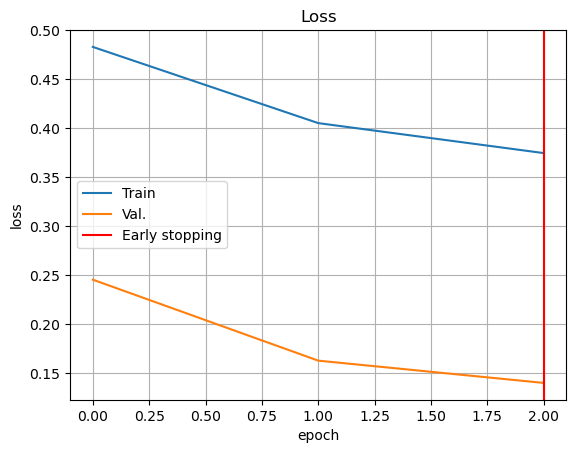

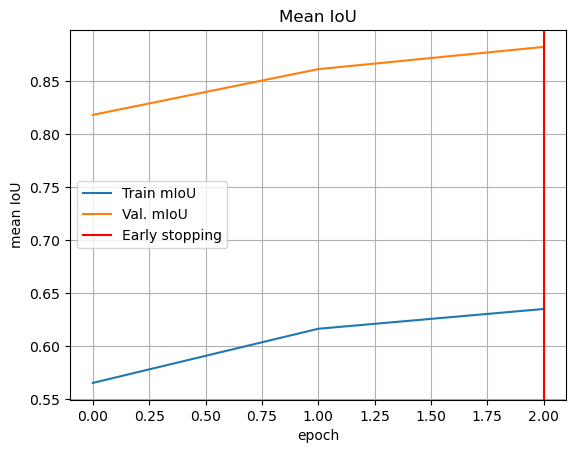

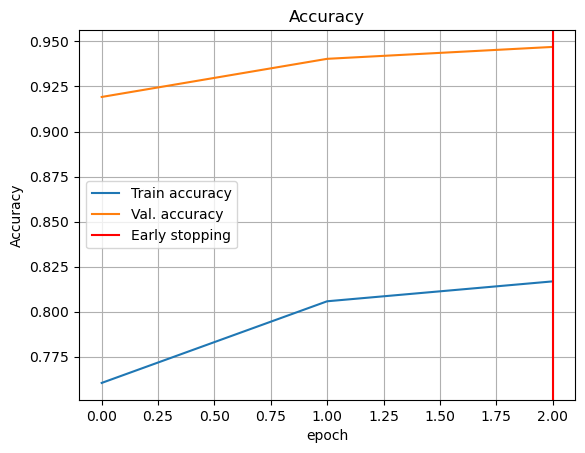

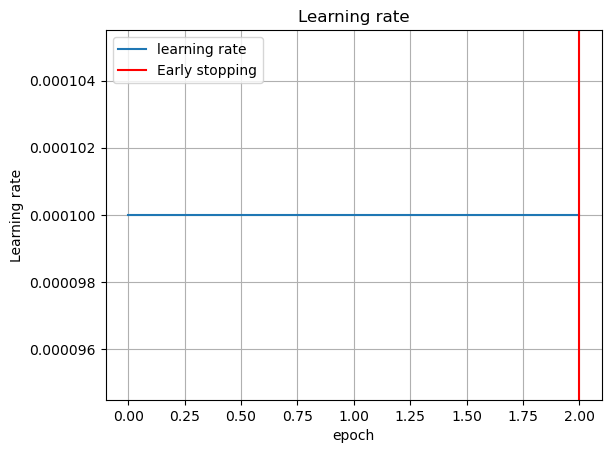

In [31]:
if args.mode == 'train':
    fig_obj = plot_loss(history)
    plt.savefig(os.path.join(EXP_PATH, 'loss_history.png')) 
    plt.savefig(os.path.join(EXP_PATH, 'loss_history.pdf')) 
    # with open(os.path.join(EXP_PATH, 'loss_history.pickle'), 'wb') as file:
    #     pickle.dump(fig_obj, file)

    fig_obj = plot_score(history)
    plt.savefig(os.path.join(EXP_PATH, 'iou_history.png')) 
    plt.savefig(os.path.join(EXP_PATH, 'iou_history.pdf')) 
    # with open(os.path.join(EXP_PATH, 'iou_history.pickle'), 'wb') as file:
    #     pickle.dump(fig_obj, file)

    fig_obj = plot_acc(history)
    plt.savefig(os.path.join(EXP_PATH, 'acc_history.png')) 
    plt.savefig(os.path.join(EXP_PATH, 'acc_history.pdf')) 
    # with open(os.path.join(EXP_PATH, 'acc_history.pickle'), 'wb') as file:
    #     pickle.dump(fig_obj, file)

    fig_obj = plot_lr(history)
    plt.savefig(os.path.join(EXP_PATH, 'lr_history.png')) 
    plt.savefig(os.path.join(EXP_PATH, 'lr_history.pdf')) 
    # with open(os.path.join(EXP_PATH, 'lr_history.pickle'), 'wb') as file:
    #     pickle.dump(fig_obj, file)

## MODEL EVALUATION
---

In [32]:
# Cria a pasta para os resultados dos experimentos
if not args.hp_optim:
    if not os.path.exists(os.path.join(EXP_PATH, f'val_images')):
        os.makedirs(os.path.join(EXP_PATH, f'val_images'))

    if not os.path.exists(os.path.join(EXP_PATH, f'val_true')):
        os.makedirs(os.path.join(EXP_PATH, f'val_true'))

    if not os.path.exists(os.path.join(EXP_PATH, f'val_pred')):
        os.makedirs(os.path.join(EXP_PATH, f'val_pred'))

    if not os.path.exists(os.path.join(EXP_PATH, f'test_images')):
        os.makedirs(os.path.join(EXP_PATH, f'test_images'))

    if not os.path.exists(os.path.join(EXP_PATH, f'test_pred')):
        os.makedirs(os.path.join(EXP_PATH, f'test_pred'))

In [33]:
# # Cria a pasta para os resultados dos experimentos
# if not args.hp_optim:
#     if not os.path.exists(os.path.join(EXP_PATH, f'val_images')):
#         os.makedirs(os.path.join(EXP_PATH, f'val_images'))

#     if not os.path.exists(os.path.join(EXP_PATH, f'val_true')):
#         os.makedirs(os.path.join(EXP_PATH, f'val_true'))

#     if not os.path.exists(os.path.join(EXP_PATH, f'val_pred')):
#         os.makedirs(os.path.join(EXP_PATH, f'val_pred'))

#     if not os.path.exists(os.path.join(EXP_PATH, f'test_images')):
#         os.makedirs(os.path.join(EXP_PATH, f'test_images'))

#     if not os.path.exists(os.path.join(EXP_PATH, f'test_pred')):
#         os.makedirs(os.path.join(EXP_PATH, f'test_pred'))

In [34]:
def visualize_image (image, mean, std):
    """
    image: torch tensor in gpu. float64. Values between 0 and 1.
    """
    if image.ndim > 3:
        image = image.squeeze(0)

    # Unnormalize all channels (ImageNet weights)
    for t, m, s in zip(image, mean, std):
        ### print(t.shape)
        t.mul_(s).add_(m)
    # The normalize code -> t.sub_(m).div_(s)

    image = image.cpu().numpy().astype(float)

    image_vis = image[0:3,:,:]

    # From Torch Tensor to NumPy
    ### image_vis = image_vis.cpu().numpy()
    # Change order from (C, H, W) to (H, W, C)
    image_vis = image_vis.transpose((1,2,0))

    return image_vis

In [35]:
smp_metric_name_lists = [
        'F1 score',
        'IoU score or Jaccard index',
        'Accuracy',
        'Precision or positive predictive value (PPV)',
        'Sensitivity, recall, or true positive rate (TPR)',
        'Sensitivity, recall, or true positive rate (TPR)',
        'Specificity, or true negative rate (TNR)',
        'Balanced accuracy',
        'Precision or positive predictive value (PPV)',
        'Negative predictive value (NPV)',
        'Miss rate or false negative rate (FNR)',
        'False positive rate (FPR)',
        'False discovery rate (FDR)',
        'False omission rate (FOR)',
        'Positive likelihood ratio (LR+)',
        'Negative likelihood ratio (LR-)'
    ]

def compute_metrics_smp(smp_stats_list, reduction='micro-imagewise'):
    """
    """
    print('compute_metrics_smp')
    smp_metric_list = [
        smp.metrics.f1_score, # F1 score
        smp.metrics.iou_score, # IoU score or Jaccard index
        smp.metrics.accuracy, # Accuracy
        smp.metrics.precision, # Precision or positive predictive value (PPV)
        smp.metrics.recall, # Sensitivity, recall, hit rate, or true positive rate (TPR)
        smp.metrics.sensitivity, # Sensitivity, recall, hit rate, or true positive rate (TPR)
        smp.metrics.specificity, # Specificity, selectivity or true negative rate (TNR)
        smp.metrics.balanced_accuracy, # Balanced accuracy
        smp.metrics.positive_predictive_value, # Precision or positive predictive value (PPV)
        smp.metrics.negative_predictive_value, # Negative predictive value (NPV)
        smp.metrics.false_negative_rate, # Miss rate or false negative rate (FNR)
        smp.metrics.false_positive_rate, # Fall-out or false positive rate (FPR)
        smp.metrics.false_discovery_rate, # False discovery rate (FDR)
        smp.metrics.false_omission_rate, # False omission rate (FOR)
        smp.metrics.positive_likelihood_ratio, # Positive likelihood ratio (LR+)
        smp.metrics.negative_likelihood_ratio, # Negative likelihood ratio (LR-)
    ]

    metric_value_list_list = []

    for stats in smp_stats_list:
        tp, fp, fn, tn = stats
        metric_value_list = []
        for i, smp_metric in enumerate(smp_metric_list):
            metric_ = smp_metric(tp, fp, fn, tn, reduction)
            ### print(metric_)
            metric_value_list.append(metric_.cpu().numpy())

        metric_value_list_list.append(metric_value_list)

    return metric_value_list_list

In [36]:
def evaluate_model_val(model, val2_set):
    print('evaluate_model_val')

    loss_list = []
    miou_list = []
    acc_list = []
    path_list = []

    pa_list = []
    ma_list = []
    m_iu_list = []
    fe_iu_list = []

    # SMP metrics
    smp_stats_list = []

    model.eval()
    model.to(device)

    with torch.no_grad():
        ### for i in tqdm(range(len(val2_set))):
        for i in range(len(val2_set)):

            image, mask, path = val2_set[i]

            image = image.unsqueeze(0).to(device)
            mask = mask.unsqueeze(0).to(device)

            # image = image.to(device)
            # mask = mask.to(device)

            # Model output (logits)
            output = model(image)
            # Model output (binary image)
            output_ = torch.max(output, 1)[0]

            if args.loss == 'crossentropy':
                loss = criterion(output, mask).item()
            elif args.loss == 'dice':
                loss = criterion(output_, mask).item()
            else:
                # Default: 'dice'
                loss = criterion(output_, mask).item()
            
            miou = mIoU(output, mask, n_classes=N_CLASSES)
            acc = pixel_accuracy_(output, mask)

            masked = torch.argmax(output, dim=1)
            ### print(masked.min(), masked.max())

            tp, fp, fn, tn = smp.metrics.get_stats(masked, mask, mode='binary', threshold=0.5)
            ### print(tp, fp, fn, tn)

            masked = masked.cpu().squeeze(0).numpy().astype(np.uint8)
            mask = mask.cpu().squeeze(0).numpy().astype(np.uint8)

            # Computa as demais métricas de validação.
            pa = pixel_accuracy(masked, mask)
            ma = mean_accuracy(masked, mask)
            m_iu = mean_IU(masked, mask)
            fe_iu = frequency_weighted_IU(masked, mask)

            # Insere as métricas de validação nas respectivas listas.
            loss_list.append(loss)
            miou_list.append(miou)
            acc_list.append(acc)
            path_list.append(path)

            pa_list.append(pa)
            ma_list.append(ma)
            m_iu_list.append(m_iu)
            fe_iu_list.append(fe_iu)

            # Compute smp metrics
            # -------------------
            smp_stats_list.append([tp, fp, fn, tn])

            if not args.hp_optim:
                # Nome do arquivo de saída.
                img_filename = str(path).split('/')[-1]

                masked_pil = Image.fromarray(masked * 255)
                masked_pil.save(os.path.join(EXP_PATH, f'val_pred', f'{img_filename}'), compression='tiff_lzw')

                if args.first_run and not args.hp_optim:
                    image_ = visualize_image(image, MEAN, STD) # Return image in float between 0 and 1.
                    image_ = img_as_ubyte(image_)

                    # Save in tiff format with uint8 and values from 0 to 255
                    image_pil = Image.fromarray(image_)
                    image_pil.save(os.path.join(EXP_PATH, f'val_images', f'{img_filename}'), compression='tiff_lzw')
                    
                    mask_pil = Image.fromarray(mask * 255)
                    mask_pil.save(os.path.join(EXP_PATH, f'val_true', f'{img_filename}'), compression='tiff_lzw')

    print('END: evaluate_model_val')

    return miou_list, acc_list, path_list, pa_list, ma_list, m_iu_list, fe_iu_list, loss_list, smp_stats_list

In [37]:
def evaluate_model_test(model, test_set):

    model.eval()
    model.to(device)

    file_details_path = os.path.join(EXP_PATH, f'segmentation_details_test.csv')
    file_details = open(file_details_path, 'w')

    file_details.write(f'\ntest set')
    file_details.write('\nId ; File path ')

    with torch.no_grad():
        ### for i in tqdm(range(len(test_set))):
        for i in range(len(test_set)):
            
            image, path = test_set[i]
            image = image.unsqueeze(0)
            image = image.to(device)
            output = model(image)

            # ----> Model output
            masked = torch.argmax(output, dim=1)

            # Convert model output to a binary image.
            masked = masked.cpu().squeeze(0).numpy().astype(np.uint8)

            # Update the report.
            file_details.write(f'\n{i} ; {path} ')
            
            if not args.hp_optim:
                # Nome do arquivo de saída.
                img_filename = str(path).split('/')[-1]

                masked_pil = Image.fromarray(masked * 255)
                masked_pil.save(os.path.join(EXP_PATH, f'test_pred', f'{img_filename}'), compression='tiff_lzw')

                if args.first_run:
                    # Return image in float between 0 and 1.
                    image_ = visualize_image(image, MEAN, STD) 
                    # Convert image to uint8 (values from 0 to 255).
                    image_ = img_as_ubyte(image_)
                    # Save in tiff format with uint8 (values from 0 to 255).
                    image_pil = Image.fromarray(image_)
                    image_pil.save(os.path.join(EXP_PATH, f'test_images', f'{img_filename}'), compression='tiff_lzw')

    file_details.close()

In [38]:
def segmentation_details(path_list, acc_list, miou_list, pa_list, ma_list, m_iu_list, fe_iu_list, loss_list, smp_metric_list_list, mode='val', reduction='micro-imagewise'):

    file_details_path = os.path.join(EXP_PATH, f'segmentation_details_{mode}_{reduction}.csv')
    file_details = open(file_details_path, 'w')

    file_details.write(f'{mode} set')
    file_details.write('\nId ; File path ; Acc ; mIoU ; pa* ; ma* ; m_iu* ; fe_iu* ; loss')
    for metric_name in smp_metric_name_lists:
        file_details.write(f'; {metric_name}')

    for i, (path, acc_, miou_, pa_, ma_, m_iu_, fe_iu_, loss_, smp_metric_list) in enumerate(zip(path_list, acc_list,  miou_list,  pa_list, ma_list, m_iu_list, fe_iu_list, loss_list, smp_metric_list_list)):
        file_details.write(f'\n{i} ; {path} ; {acc_} ; {miou_} ; {pa_} ; {ma_} ; {m_iu_} ; {fe_iu_} ; {loss_}')

        for smp_metric in smp_metric_list:
            file_details.write(f' ; {smp_metric}')

    file_details.close()

### Evaluating over the validation set

In [39]:
miou_val, acc_val, path_list_val, pa_list, ma_list, m_iu_list, fe_iu_list, loss_list, smp_stats_list = evaluate_model_val(model, val2_set)
# TEST
print(len(path_list_val))
print(len(miou_val))
print(len(acc_val))
print(len(smp_stats_list))


evaluate_model_val
END: evaluate_model_val
2520
2520
2520
2520


In [40]:
print('>> compute_metrics_smp')
### smp_metric_list_list = compute_metrics_smp(smp_stats_list, args.smp_reduction)
smp_metric_list_list_micro_iw = compute_metrics_smp(smp_stats_list, 'micro-imagewise')
smp_metric_list_list_macro_iw = compute_metrics_smp(smp_stats_list, 'macro-imagewise')
smp_metric_list_list_micro = compute_metrics_smp(smp_stats_list, 'micro')
smp_metric_list_list_macro = compute_metrics_smp(smp_stats_list, 'macro')

>> compute_metrics_smp
compute_metrics_smp
compute_metrics_smp
compute_metrics_smp
compute_metrics_smp


In [41]:
print('>> segmentation_details')
segmentation_details(path_list_val, acc_val, miou_val, pa_list, ma_list, m_iu_list, fe_iu_list, loss_list, smp_metric_list_list_micro_iw, 'val', 'micro-imagewise')
segmentation_details(path_list_val, acc_val, miou_val, pa_list, ma_list, m_iu_list, fe_iu_list, loss_list, smp_metric_list_list_macro_iw, 'val', 'macro-imagewise')
segmentation_details(path_list_val, acc_val, miou_val, pa_list, ma_list, m_iu_list, fe_iu_list, loss_list, smp_metric_list_list_micro, 'val', 'micro')
segmentation_details(path_list_val, acc_val, miou_val, pa_list, ma_list, m_iu_list, fe_iu_list, loss_list, smp_metric_list_list_macro, 'val', 'macro')

>> segmentation_details


In [42]:
print('Validation set loss: ', np.mean(loss_list))
print('Validation set Pixel Accuracy: ', np.mean(acc_val))
print('Validation set mIoU: ', np.mean(miou_val))
print('Validation pixel_accuracy*: ', np.mean(pa_list)) 
print('Validation mean_accuracy*: ', np.mean(ma_list))
print('Validation mean_IU*: ', np.mean(m_iu_list))
print('Validation frequency_weighted_IU*: ', np.mean(fe_iu_list)) 

with open(os.path.join(EXP_PATH, f'general_report.txt'), 'a') as model_file:
        model_file.write(f'\n\nValidation set loss: {np.mean(loss_list)}')
        model_file.write(f'\nValidation set Pixel Accuracy: {np.mean(acc_val)}')
        model_file.write(f'\nValidation set mIoU: {np.mean(miou_val)}')
        model_file.write(f'\nValidation pixel_accuracy*: {np.mean(pa_list)}') 
        model_file.write(f'\nValidation mean_accuracy*: {np.mean(ma_list)}')
        model_file.write(f'\nValidation mean_IU*: {np.mean(m_iu_list)}')
        model_file.write(f'\nValidation frequency_weighted_IU*: {np.mean(fe_iu_list)}') 

Validation set loss:  0.13852859235549758
Validation set Pixel Accuracy:  0.9478949787335001
Validation set mIoU:  0.8436622719993205
Validation pixel_accuracy*:  0.9478949787335001
Validation mean_accuracy*:  0.8841221516845984
Validation mean_IU*:  0.8436622719991529
Validation frequency_weighted_IU*:  0.922896031393293


In [43]:
def gen_general_rep(smp_reduction, smp_metric_list_list):
    print('\nGenerating general report...')
    # O nome de um arquivo CSV. Irá armazenar todos os losses e acuracias.
    hp_filename = os.path.join(EXP_PATH_MAIN, f'general_report_val_smp_{smp_reduction}.csv')

    if args.ec == 0:
        # Cria o arquivo CSV
        hp_file = open(hp_filename, 'w')

        # Cria cabeçalho
        header = '#;DS;MODEL;ENCODER;FT;BS;LR;EP;SCHEDULER;' + \
                 'ES;LOSS;ACC;mIoU;PA*;MA*;M_IU*;FE_IU*' 
        
        # Header for smp metrics
        for metric_name in smp_metric_name_lists:
            header += f';{metric_name}'

        hp_file.write(header)

    else:
        # Cria o arquivo CSV
        hp_file = open(hp_filename, 'a')

    info = f'\n{args.ec};{args.dataset_name};{args.model};{args.backbone};{args.pretrained};{args.batch_size};{args.lr};{args.max_epochs};{args.scheduler};' + \
           f'{best_epoch};{np.mean(loss_list)};{np.mean(acc_val)};{np.mean(miou_val)};{np.mean(pa_list)};{np.mean(ma_list)};{np.mean(m_iu_list)};{np.mean(fe_iu_list)}' 

    # SMP metrics means
    smp_metric_mean = np.mean(smp_metric_list_list, axis=0)

    # SMP metrics
    for smp_metric in zip(smp_metric_mean):
        info += f';{smp_metric[0]}' 

    hp_file.write(info)

    hp_file.close()

In [44]:
gen_general_rep('micro-imagewise', smp_metric_list_list_micro_iw)
gen_general_rep('macro-imagewise', smp_metric_list_list_macro_iw)
gen_general_rep('micro', smp_metric_list_list_micro)
gen_general_rep('macro', smp_metric_list_list_macro)


Generating general report...

Generating general report...

Generating general report...

Generating general report...


In [45]:
def gen_general_rep_std(smp_reduction, smp_metric_list_list):
    print('\nGenerating general report...')
    # O nome de um arquivo CSV. Irá armazenar todos os losses e acuracias.
    hp_filename = os.path.join(EXP_PATH_MAIN, f'general_report_val_smp_{smp_reduction}_std.csv')

    if args.ec == 0:
        # Cria o arquivo CSV
        hp_file = open(hp_filename, 'w')

        # Cria cabeçalho
        header = '#;DS;MODEL;ENCODER;FT;BS;LR;EP;SCHEDULER;' + \
                 'ES;LOSS;ACC;mIoU;PA*;MA*;M_IU*;FE_IU*' 
        
        # Header for smp metrics
        for metric_name in smp_metric_name_lists:
            header += f';{metric_name}'

        hp_file.write(header)

    else:
        # Cria o arquivo CSV
        hp_file = open(hp_filename, 'a')

    info = f'\n{args.ec};{args.dataset_name};{args.model};{args.backbone};{args.pretrained};{args.batch_size};{args.lr};{args.max_epochs};{args.scheduler};' + \
           f'{best_epoch};{np.std(loss_list)};{np.std(acc_val)};{np.std(miou_val)};{np.std(pa_list)};{np.std(ma_list)};{np.std(m_iu_list)};{np.std(fe_iu_list)}' 

    # SMP metrics means
    smp_metric_std = np.std(smp_metric_list_list, axis=0)

    # SMP metrics
    for smp_metric in zip(smp_metric_std):
        info += f';{smp_metric[0]}' 

    hp_file.write(info)

    hp_file.close()

In [46]:
gen_general_rep_std('micro-imagewise', smp_metric_list_list_micro_iw)
gen_general_rep_std('macro-imagewise', smp_metric_list_list_macro_iw)
gen_general_rep_std('micro', smp_metric_list_list_micro)
gen_general_rep_std('macro', smp_metric_list_list_macro)


Generating general report...

Generating general report...

Generating general report...

Generating general report...


/home/joao/anaconda3/envs/env-smp-py39/lib/python3.9/site-packages/numpy/core/_methods.py:236: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


### Evaluation over the testing set


In [47]:
if not args.hp_optim:
    evaluate_model_test(model, test_set)

In [ ]:
with open(os.path.join(EXP_PATH, f'general_report.txt'), 'a') as model_file:
        model_file.write(f'\n\nDone!')

# Se o arquivo "done.txt" estiver na pasta, o experimento foi finalizado com sucesso!
done_file = open(os.path.join(EXP_PATH, 'done.txt'), 'w')
done_file.close()

print('\nDone!')


Done!


: 